#### Copyright 2024 The TensorFlow Probability Authors.

```none
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```

# Probabilistic Bundle Adjustment

This notebook shows how to use probabilistic modeling and inference to solve the bundle adjustment problem. Given a video of keypoints, we construct a probabilistic generative model that can reconstruct that video given camera poses and keypoint world positions. We then use Markov Chain Monte Carlo (MCMC) to perform probabilistic inference on this model to infer the unknown camera poses and keypoint world positions.

In an uncommon choice, this notebook illustrates how to construct an interactive inference controller that enables monitoring and adjusting the model and inference hyperparameters to gain a better understanding of the model and inference procedure. As a result, **this notebook must be run in Jupyter Lab**, with a GPU. Running on Google Colab will cause the UI elements to not function correctly (the batch inference should be fine however).


# Setup

In [2]:
import jax
import numpy as np
if False:
    jax.config.update("jax_enable_x64", True)
    DTYPE = np.float64
else:
    DTYPE = np.float32

In [3]:
import abc
import asyncio
import collections
from collections.abc import Callable
import copy
import contextlib
import dataclasses
import functools
import io
import time
from typing import Any, NamedTuple, Optional, TypeVar
import traceback

import fun_mc.using_jax as fun_mc
import ipywidgets
import jax.numpy as jnp
from jax.scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt
import mediapy
import plotly.graph_objects as pgo
import pythreejs as p3
import tqdm.notebook
import tensorflow_probability.substrates.jax as tfp
import warnings

tfd = tfp.distributions
tfb = tfp.bijectors

In [4]:
INTERACTIVE_INFERENCE = None

# Utils

## Misc

In [5]:
def shape(*args):
    if len(args) == 1:
        args = args[0]
    return jax.tree.map(jnp.shape, args)


def dtype(*args):
    if len(args) == 1:
        args = args[0]
    return jax.tree.map(jnp.dtype, args)


def cast_floats(x, dtype=DTYPE):
    def one_part(x):
        if jnp.issubdtype(x.dtype, jnp.floating):
            return x.astype(dtype)
        else:
            return x

    return jax.tree.map(one_part, x)


def to_html(color):
    return (
        f"#{int(255 * color[0]):02X}{int(255 * color[1]):02X}{int(255 * color[2]):02X}"
    )


COLORS = [  # From https://mikemol.github.io/technique/colorblind/2018/02/11/color-safe-palette.html
    "#E69F00",
    "#56B4E9",
    "#009E73",
    "#0072B2",
    "#D55E00",
    "#F0E442",
    "#CC79A7",
]

new_order = [2, 3, 4, 0, 1, 5]  # from luminance, reversed
COLORS = list(np.array(COLORS)[new_order])

COLORS_NP = (
    np.stack(
        [
            np.stack(
                [
                    int(c[1:3], base=16),
                    int(c[3:5], base=16),
                    int(c[5:7], base=16),
                ]
            )
            for c in COLORS
        ]
    )
    / 255.0
)

import cycler

plt.rcParams["axes.prop_cycle"] = cycler.cycler(color=COLORS)

## Pose

In [6]:
class Pose(NamedTuple):
    position: jax.Array
    quaternion: jax.Array

    def rotation(self) -> Rotation:
        return Rotation.from_quat(self.quaternion)

    def normalize(self) -> "Pose":
        return Pose(self.position, self.rotation().as_quat())

    def apply(self, vec: jax.Array) -> jax.Array:
        return self.rotation().apply(vec) + self.position

    def compose(self, other: "Pose") -> "Pose":
        new_position = self.apply(other.position)
        new_quaternion = (self.rotation() * other.rotation()).as_quat()
        return Pose(new_position, new_quaternion)

    def inv(self) -> "Pose":
        inv_rot = self.rotation().inv()
        return Pose(-inv_rot.apply(self.position), inv_rot.as_quat())

    @classmethod
    def identity(cls) -> "Pose":
        return cls(position=jnp.zeros(3), quaternion=jnp.array([0.0, 0.0, 0.0, 1.0]))

    def __getitem__(self, idx):
        return jax.tree.map(lambda x: x[idx], self)

## Camera

In [7]:
@functools.partial(jax.vmap, in_axes=(0, None))
def screen_from_camera(xyz, camera_pose):
    with jax.default_matmul_precision("float32"):
        cam_xyz = camera_pose.inv().apply(xyz)
        x, y, z = cam_xyz
        # HACK: Why does this work?
        z = jnp.where(z < 1e-3, 1e-3, z)
        u = x / z
        v = y / z
        return jnp.stack([u, v], axis=-1)


def homogeneous_coordinates(uv, z=np.array(1.0, DTYPE)):
    return (
        jnp.concatenate([uv, jnp.ones_like(uv[..., :1])], axis=-1) * z[..., jnp.newaxis]
    )


def look_at_quat(position, target, up=np.array([0.0, 0.0, 1.0], DTYPE)):
    z = target - position
    z = z / jnp.linalg.norm(z)

    x = jnp.cross(z, up)
    x = x / jnp.linalg.norm(x)

    y = jnp.cross(z, x)
    y = y / jnp.linalg.norm(y)

    rotation_matrix = jnp.hstack([x.reshape(-1, 1), y.reshape(-1, 1), z.reshape(-1, 1)])
    return Rotation.from_matrix(rotation_matrix).as_quat()

## Scene

In [8]:
@dataclasses.dataclass
class Scene:
    keypoint_world_positions: jax.Array
    keypoint_colors: jax.Array
    keypoint_screen_positions: jax.Array
    camera_poses: jax.Array
    keypoint_visibility: jax.Array

    @property
    def num_frames(self) -> int:
        return self.keypoint_screen_positions.shape[0]

    @property
    def num_keypoints(self) -> int:
        return self.keypoint_screen_positions.shape[1]


def make_scene(obj, camera_poses, max_num_points):
    points, rgbs = scene_obj.spawn_points(max_num_points, jax.random.key(0))
    visibility = ~jax.lax.map(
        lambda camera_pos: cast_ray_one_frame(camera_pos, points, scene_obj),
        camera_positions,
    )
    uvs = jax.lax.map(
        lambda camera_pose: screen_from_camera(points, camera_pose), camera_poses
    )
    visibility &= jnp.linalg.norm(uvs, axis=-1, ord=jnp.inf) < 1
    valid_keypoints = visibility.any(0)

    return Scene(
        keypoint_world_positions=points[valid_keypoints],
        keypoint_colors=rgbs[valid_keypoints],
        keypoint_screen_positions=uvs[:, valid_keypoints],
        keypoint_visibility=visibility[:, valid_keypoints],
        camera_poses=camera_poses,
    )


@dataclasses.dataclass
class SceneInfo:
    object_mask: jax.Array
    object_positions: jax.Array

## Scene Rendering

In [9]:
POINT_VERTEX = """
attribute float size;
attribute vec3 color;

varying vec3 var_color;
varying float var_size;

void main() {
    var_color = color;
    gl_Position = projectionMatrix * modelViewMatrix * vec4(position, 1.0);
    gl_PointSize = size;
    var_size = size;
}
"""

POINT_FRAGMENT = """
varying vec3 var_color;
varying float var_size;

void main() {
    gl_FragColor = vec4(var_color, 1.0);
    if (var_size < 0.0001)
        discard;
}
"""


def octahedron():
    vertices = np.array(
        [
            [0, 1, 0],
            [1, 0, 0],
            [0, 0, 1],
            [-1, 0, 0],
            [0, 0, -1],
            [0, -1, 0],
        ]
    ).astype(np.float32)

    indices = (
        np.array(
            [
                [1, 0, 2],
                [2, 0, 3],
                [3, 0, 4],
                [4, 0, 1],
                [2, 5, 1],
                [3, 5, 2],
                [4, 5, 3],
                [1, 5, 4],
            ]
        )
        .astype(np.uint32)
        .ravel()
    )
    return vertices, indices


def camera_frustum():
    vertices = np.array(
        [
            [0, 0, 0],
            [1, 1, 1],
            [-1, 1, 1],
            [-1, -1, 1],
            [1, -1, 1],
            [-1, -1.1, 1],
            [0, -1.5, 1],
            [1, -1.1, 1],
        ]
    ).astype(np.float32)

    indices = (
        np.array(
            [
                [0, 1, 2],
                [0, 2, 3],
                [0, 3, 4],
                [0, 4, 1],
                [5, 6, 7],
            ]
        )
        .astype(np.uint32)
        .ravel()
    )
    return vertices, indices


@jax.jit
@functools.partial(jax.vmap, in_axes=(None, 0, 0))
def transform(xs, cov, loc):
    v, s, _ = jnp.linalg.svd(cov)
    return (v @ (jnp.sqrt(s) * xs).T).T + loc


@jax.jit
@functools.partial(jax.vmap, in_axes=(None, 0, 0))
def transform_pose(xs, quat, loc):
    return Rotation(quat).apply(xs) + loc


@jax.jit
@functools.partial(jax.vmap, in_axes=(1,))
def get_loc_cov(xs):
    return (
        xs.mean(0),
        jnp.cov(xs, rowvar=False),
    )


@dataclasses.dataclass
class PointsDisplay:
    def __init__(self, positions, colors, point_size=4.0):
        self.point_size = point_size

        point_material = p3.ShaderMaterial(
            vertexShader=POINT_VERTEX,
            fragmentShader=POINT_FRAGMENT,
        )

        self.points_geometry = p3.BufferGeometry(
            attributes={
                "position": p3.BufferAttribute(array=positions),
                "color": p3.BufferAttribute(array=colors),
                "size": p3.BufferAttribute(
                    array=self.point_size * np.ones(colors.shape[0], dtype=np.float32)
                ),
            }
        )
        self.points = p3.Points(
            self.points_geometry,
            point_material,
        )

    def set_state(
        self,
        positions,
        size=None,
    ):
        self.points_geometry.attributes["position"].array = positions

    def set_mask(self, mask):
        self.points_geometry.attributes["size"].array = self.point_size * mask.astype(
            np.float32
        )

    @property
    def objects(self):
        return [self.points]


@dataclasses.dataclass
class CameraDisplay:
    def __init__(
        self,
        positions,
        quaternions,
        color,
        size=0.05,
    ):
        self.vertices, self.indices = camera_frustum()
        self.vertices = size * self.vertices
        point_material = p3.ShaderMaterial(
            vertexShader=POINT_VERTEX,
            fragmentShader=POINT_FRAGMENT,
            wireframe=True,
        )

        self.cameras_geometry = p3.BufferGeometry(
            attributes={
                "position": p3.BufferAttribute(
                    array=transform_pose(
                        self.vertices,
                        quaternions,
                        positions,
                    )
                ),
                "color": p3.BufferAttribute(
                    array=np.repeat(
                        np.asarray(color)[np.newaxis],
                        positions.shape[0] * len(self.vertices),
                        axis=0,
                    ).astype(np.float32)
                ),
                "size": p3.BufferAttribute(
                    array=np.ones(
                        positions.shape[0] * len(self.vertices),
                        dtype=np.float32,
                    )
                ),
                "index": p3.BufferAttribute(
                    array=(
                        self.indices[np.newaxis]
                        + len(self.vertices)
                        * np.arange(positions.shape[0])[:, jnp.newaxis]
                    )
                    .astype(np.uint32)
                    .ravel(),
                ),
            }
        )
        self.cameras = p3.Mesh(
            self.cameras_geometry,
            point_material,
        )

    def set_state(
        self,
        positions,
        quaternions,
    ):
        self.cameras_geometry.attributes["position"].array = transform_pose(
            self.vertices,
            quaternions,
            positions,
        )

    def set_mask(self, mask):
        self.cameras_geometry.attributes["size"].array = np.repeat(
            mask.astype(np.float32),
            np.full(mask.shape[0], len(self.vertices)),
            axis=0,
        )

    @property
    def objects(self):
        return [self.cameras]


@dataclasses.dataclass
class BlobDisplay:
    def __init__(
        self,
        positions,
        covariances,
        colors,
    ):
        self.vertices, self.indices = octahedron()
        point_material = p3.ShaderMaterial(
            vertexShader=POINT_VERTEX,
            fragmentShader=POINT_FRAGMENT,
        )

        self.blobs_geometry = p3.BufferGeometry(
            attributes={
                "position": p3.BufferAttribute(
                    array=transform(
                        self.vertices,
                        covariances,
                        positions,
                    )
                ),
                "color": p3.BufferAttribute(
                    array=np.repeat(
                        colors,
                        np.full(colors.shape[0], len(self.vertices)),
                        axis=0,
                    )
                ),
                "size": p3.BufferAttribute(
                    array=np.ones(
                        colors.shape[0] * len(self.vertices),
                        dtype=np.float32,
                    )
                ),
                "index": p3.BufferAttribute(
                    array=(
                        self.indices[np.newaxis]
                        + len(self.vertices)
                        * np.arange(colors.shape[0])[:, jnp.newaxis]
                    )
                    .astype(np.uint32)
                    .ravel(),
                ),
            }
        )
        self.blobs = p3.Mesh(
            self.blobs_geometry,
            point_material,
        )

    def set_state(
        self,
        positions,
        covariances,
    ):
        self.blobs_geometry.attributes["position"].array = transform(
            self.vertices,
            covariances,
            positions,
        )

    def set_mask(self, mask):
        self.blobs_geometry.attributes["size"].array = np.repeat(
            mask.astype(np.float32),
            np.full(mask.shape[0], len(self.vertices)),
            axis=0,
        )

    @property
    def objects(self):
        return [self.blobs]


@dataclasses.dataclass
class SceneRenderer:
    def __init__(self, objects, up=[0, 0, 1]):
        width = 800
        height = 600

        camera = p3.PerspectiveCamera(
            position=[5, 5, 5],
            up=up,
            aspect=width / height,
        )
        # grid = p3.GridHelper(10, 10)
        # grid.rotateX(np.pi / 2)
        self.scene = p3.Scene(
            children=[camera, p3.AxesHelper(1)] + objects, background="black"
        )
        self.renderer = p3.Renderer(
            camera=camera,
            scene=self.scene,
            controls=[p3.OrbitControls(controlling=camera)],
            width=width,
            height=height,
        )

    def _ipython_display_(self):
        display(self.renderer)

## DirectionRadius

In [10]:
class DirectionRadius(tfd.Distribution):
    def __init__(
        self,
        ndims,
        sphere_dist,
        radius_dist,
        allow_nan_stats=True,
        validate_args=False,
        name="DirectionRadius",
    ):
        parameters = dict(locals())
        self.ndims = ndims
        self.sphere_dist = sphere_dist
        self.radius_dist = radius_dist
        super().__init__(
            dtype=radius_dist.dtype,
            reparameterization_type=tfd.FULLY_REPARAMETERIZED,
            allow_nan_stats=allow_nan_stats,
            validate_args=validate_args,
            parameters=parameters,
            name=name,
        )

    def _parameter_properties(self, dtype=None, num_classes=None):
        return dict(
            sphere_dist=tfp.util.BatchedComponentProperties(),
            radius_dist=tfp.util.BatchedComponentProperties(),
        )

    def _sample_n(self, n, seed):
        pos_seed, rad_seed = jax.random.split(seed)
        if self.sphere_dist is None:
            pos = jax.random.normal(
                pos_seed,
                (
                    n,
                    self.ndims,
                ),
                self.dtype,
            )
            # TODO: Properly handle sampling the origin.
            pos /= jnp.maximum(
                jnp.finfo(self.dtype).eps, jnp.linalg.norm(pos, axis=-1, keepdims=True)
            )
        else:
            pos = self.sphere_dist.sample(n, seed=pos_seed)
        rad = self.radius_dist.sample(n, seed=rad_seed)
        return rad[:, jnp.newaxis] * pos

    def _log_prob(self, x):
        rad = jnp.linalg.norm(x, axis=-1)
        n = self.ndims
        if self.sphere_dist is None:
            log_z = (
                jnp.log(2).astype(self.dtype)
                + n / 2.0 * jnp.log(jnp.pi).astype(self.dtype)
                - jax.scipy.special.gammaln(n / 2)
            )
            sphere_lp = -log_z
        else:
            sphere_lp = self.sphere_dist.log_prob(x / rad[..., jnp.newaxis])
        # TODO: Properly handle evaluating at the origin.
        res = (
            self.radius_dist.log_prob(rad)
            - (n - 1) * jnp.log(rad).astype(self.dtype)
            + sphere_lp
        )
        return res

    @property
    def event_shape(self):
        return tfp.tf2jax.TensorShape([self.ndims])

    def event_shape_tensor(self):
        return jnp.asarray(self.event_shape)

## DonutDist

In [11]:
def make_donut_dist(n, loc, dir, conc, r, k):
    dd = tfd.PowerSpherical(dir, conc)
    # rd = tfd.Chi2(k)
    rd = tfd.Gamma(k, 1.0)
    return tfb.Chain([tfb.Shift(loc), tfb.Scale(r / rd.mode())])(
        DirectionRadius(n, dd, rd)
    )

## InverseGamma

In [12]:
d = tfd.InverseGamma(jnp.array(2.0, DTYPE), 1.0)
inverse_gamma_bij = d.experimental_default_event_space_bijector()


def make_unc_inverse_gamma(*args):
    return tfb.Invert(inverse_gamma_bij)(tfd.InverseGamma(*args))


observation_noise_scale_bij = inverse_gamma_bij

## Objects

In [13]:
COLLISION_EPS = 1e-3


class Cuboid(NamedTuple):
    position: jax.Array
    size: jax.Array
    color: jax.Array

    def min(self):
        return self.position - self.size / 2

    def max(self):
        return self.position + self.size / 2

    def contains(self, point: jax.Array) -> jax.Array:
        return (
            (point > (self.min() + COLLISION_EPS))
            & (point < (self.max() - COLLISION_EPS))
        ).all()

    def spawn_points(self, num_points, seed):
        points = jax.random.normal(seed, [num_points, 3])
        # This isn't a great way to do this, density is not uniform on each face.
        points /= jnp.linalg.norm(points, axis=-1, ord=jnp.inf, keepdims=True)
        return self.position + self.size / 2 * points, jnp.broadcast_to(
            self.color, [num_points, 3]
        )


class Sphere(NamedTuple):
    position: jax.Array
    size: jax.Array
    color: jax.Array

    def contains(self, point: jax.Array) -> jax.Array:
        return (
            jnp.linalg.norm(point - self.position, axis=-1)
            < self.size / 2 - COLLISION_EPS
        )

    def spawn_points(self, num_points, seed):
        points = jax.random.normal(seed, [num_points, 3])
        points /= jnp.linalg.norm(points, axis=-1, keepdims=True)
        return self.position + self.size / 2 * points, jnp.broadcast_to(
            self.color, [num_points, 3]
        )


class MultiObject(NamedTuple):
    objects: Any

    def contains(self, point: jax.Array) -> jax.Array:
        contains = jnp.array(False)
        for obj in self.objects:
            contains |= obj.contains(point)
        return contains

    def spawn_points(self, num_points, seed):
        all_points = []
        all_rgbs = []
        for i, obj in enumerate(self.objects):
            n = (i + 1) * num_points // (len(self.objects)) - i * num_points // (
                len(self.objects)
            )
            points, rgbs = obj.spawn_points(n, jax.random.fold_in(seed, i))
            all_points.append(points)
            all_rgbs.append(rgbs)
        return jnp.concatenate(all_points, 0), jnp.concatenate(all_rgbs, 0)


def cast_ray(source, target, obj, num_points=50):
    t = jnp.linspace(0.0, 1.0, num_points)
    points = source + (target - source) * t[:, jnp.newaxis]
    hit = jax.vmap(obj.contains)(points)
    return hit.any()


cast_ray_one_frame = jax.vmap(cast_ray, in_axes=(None, 0, None))

## Effect Handling

In [14]:
T = TypeVar("T")


@dataclasses.dataclass
class Effect:
    name: str

    def set_value(self, value: Any) -> Any:
        raise NotImplementedError(f"{type(self)}")

    def value(self) -> Any:
        raise NotImplementedError(f"{type(self)}")


@dataclasses.dataclass
class SampleEffect(Effect):
    dist: tfd.Distribution

    def set_value(self, value: Any) -> "SampleValueEffect":
        return SampleValueEffect(name=self.name, dist=self.dist, value_=value)


@dataclasses.dataclass
class SampleValueEffect(Effect):
    dist: tfd.Distribution
    value_: Optional[Any] = None

    def set_value(self, value: Any) -> "SampleValueEffect":
        return dataclasses.replace(self, value_=value)

    def value(self):
        return self.value_


@dataclasses.dataclass
class Handler(metaclass=abc.ABCMeta):
    @abc.abstractmethod
    def __call__(self, effect: Effect) -> tuple[Any, Effect]:
        pass

    def result(self) -> dict[str, Any]:
        return {}


@dataclasses.dataclass
class LogProb(Handler):
    log_prob: jnp.ndarray = dataclasses.field(
        default_factory=lambda: jnp.zeros([], DTYPE)
    )

    def __call__(self, effect: Effect) -> tuple[Any, Effect]:
        res = self
        if isinstance(effect, SampleValueEffect):
            res = dataclasses.replace(
                res, log_prob=res.log_prob + effect.dist.log_prob(effect.value())
            )
        return res, effect

    def result(self):
        return {"log_prob": self.log_prob}


@dataclasses.dataclass
class Sample(Handler):
    seed: jax.Array

    def __call__(self, effect: Effect) -> tuple[Any, Effect]:
        res = self
        if isinstance(effect, SampleEffect):
            new_seed, seed = jax.random.split(self.seed)
            res = dataclasses.replace(res, seed=new_seed)
            effect = SampleValueEffect(
                name=effect.name,
                dist=effect.dist,
                value_=effect.dist.sample(seed=seed),
            )
        return res, effect


@dataclasses.dataclass
class SetValues(Handler):
    values: dict[str, jnp.ndarray]

    def __call__(self, effect: Effect) -> tuple[Any, Effect]:
        value = self.values.get(effect.name)
        if value is not None:
            effect = effect.set_value(value)
        return self, effect


@dataclasses.dataclass
class Collect(Handler):
    get_fn: Callable[[Effect], Any] = lambda x: x
    filter_fn: Callable[[Effect], bool] = lambda x: True
    results: dict[str, Any] = dataclasses.field(default_factory=dict)

    def __call__(self, effect: Effect) -> tuple[Any, Effect]:
        res = self
        if self.filter_fn(effect):
            res = dataclasses.replace(
                res, results={effect.name: self.get_fn(effect), **res.results}
            )
        return res, effect

    def result(self):
        return {"results": self.results}


_handler_stack = []


@contextlib.contextmanager
def apply_handlers(*handlers: Handler):
    global _handler_stack
    old_len = len(_handler_stack)
    _handler_stack.extend(handlers)
    res = {}
    try:
        yield res
    finally:
        for handler in _handler_stack[old_len:]:
            res.update(handler.result())
        _handler_stack = _handler_stack[:old_len]


def effect(effect: Effect) -> Any:
    for i in range(len(_handler_stack)):
        _handler_stack[i], effect = _handler_stack[i](effect)
    return effect.value()


def sample(name: str, dist: tfd.Distribution) -> jnp.ndarray:
    return effect(SampleEffect(name=name, dist=dist))


def model_sample(
    model_fn: Callable[[], T], seed: jax.Array
) -> tuple[dict[str, Any], T]:
    with apply_handlers(Sample(seed), Collect(lambda e: e.value())) as trace:
        res = model_fn()

    return trace["results"], res


def model_cond_sample(
    model_fn: Callable[[], T], value: dict[str, Any], seed: jax.Array
) -> tuple[dict[str, Any], T]:
    with apply_handlers(
        SetValues(value), Sample(seed), Collect(lambda e: e.value())
    ) as trace:
        res = model_fn()

    return trace["results"], res


def model_log_prob(
    model_fn: Callable[[], T], value: dict[str, Any]
) -> tuple[jnp.ndarray, T]:
    with apply_handlers(SetValues(value), LogProb()) as trace:
        res = model_fn()

    return trace["log_prob"], res


def model_log_prob_ratio(
    model_fn: Callable[[], T],
    value1: dict[str, Any],
    value2: dict[str, Any],
) -> tuple[jnp.ndarray, T]:
    with apply_handlers(
        SetValues(value1), Collect(lambda e: (e.dist, e.value()))
    ) as trace1:
        res1 = model_fn()

    with apply_handlers(
        SetValues(value2), Collect(lambda e: (e.dist, e.value()))
    ) as trace2:
        res2 = model_fn()

    log_prob_ratio = 0
    for k in trace1["results"].keys():
        d1, x1 = trace1["results"][k]
        d2, x2 = trace2["results"][k]
        log_prob_ratio += tfp.experimental.distributions.log_prob_ratio(d1, x1, d2, x2)

    return log_prob_ratio, [res1, res2]

In [15]:
def model():
    x = sample("x", tfd.Normal(0.0, 1.0))
    y = sample("y", tfd.Normal(x, 1.0))
    return [x, y]


s1, _ = model_sample(model, jax.random.key(0))
s2, _ = model_sample(model, jax.random.key(1))
lp1 = model_log_prob(model, s1)[0]
lp2 = model_log_prob(model, s2)[0]
print(lp1, lp2, lp1 - lp2)
print(model_log_prob_ratio(model, s1, s2)[0])

-2.7931314 -3.092115 0.29898357
0.2989837


## UI Hyperparameter

In [16]:
@dataclasses.dataclass
class Hyperparameter:
    value: Any
    min: Any = None
    max: Any = None
    log_scale: bool = False


def make_hyperparameter_widget(
    hparam,
    name,
    output=contextlib.nullcontext(),
    callback_fn=lambda _: None,
    toggle_style="",
    toggle_icons=("check-circle-o", "circle-o"),
):
    integer = np.issubdtype(np.array(hparam.value).dtype, np.integer)
    boolean = np.issubdtype(np.array(hparam.value).dtype, np.bool_)

    def toggle_icon(val):
        if val:
            return toggle_icons[0]
        else:
            return toggle_icons[1]

    def on_value_change(change):
        try:
            hparam.value = change["new"]
            if boolean:
                widget.icon = toggle_icon(hparam.value)
            callback_fn(hparam.value)
        except Exception:
            with output:
                print(traceback.format_exc())

    if boolean:
        widget = ipywidgets.ToggleButton(
            value=hparam.value,
            description=name,
            icon=toggle_icon(hparam.value),
            button_style=toggle_style,
        )

    elif integer:
        widget = ipywidgets.IntSlider(
            value=hparam.value,
            min=hparam.min,
            max=hparam.max,
            description=name,
            layout=ipywidgets.Layout(width="500px"),
            style={"description_width": "200px"},
        )
    elif hparam.log_scale:
        widget = ipywidgets.FloatLogSlider(
            value=hparam.value,
            base=10,
            min=np.log10(hparam.min),
            max=np.log10(hparam.max),
            step=0.05,
            description=name,
            layout=ipywidgets.Layout(width="500px"),
            style={"description_width": "200px"},
        )
    else:
        widget = ipywidgets.FloatSlider(
            value=hparam.value,
            min=hparam.min,
            max=hparam.max,
            description=name,
            layout=ipywidgets.Layout(width="500px"),
            style={"description_width": "200px"},
        )
    widget.observe(on_value_change, names="value")
    return widget

# Synthetic Data

In [17]:
scene_obj = MultiObject(
    [
        Cuboid(
            position=jnp.array([0.0, 0.0, 1.0]),
            size=jnp.array([1.0, 2.0, 3.0]),
            color=COLORS_NP[0],
        ),
        Cuboid(
            position=jnp.array([0.0, 0.0, 1.0]),
            size=jnp.array([3.0, 1.0, 1.0]),
            color=COLORS_NP[1],
        ),
        Sphere(
            position=jnp.array([0.0, 1.0, 0.0]),
            size=2.0,
            color=COLORS_NP[2],
        ),
    ]
)

num_frames = 100
raw_t = jnp.linspace(-1.0, 1.0, num_frames)
t = (1 + jnp.sign(raw_t) * jnp.abs(raw_t) ** 0.7) / 2
theta = jnp.pi / 4 + t * 3 * jnp.pi / 4
r = jnp.linspace(3.0, 4.0, num_frames)
x = r * jnp.cos(theta)
y = r * jnp.sin(theta)
z = -0.5 + t + jnp.cos(theta * 3)
camera_positions = jnp.stack([x, y, z], -1)
camera_quaternions = jax.vmap(look_at_quat, in_axes=(0, None))(
    camera_positions, jnp.zeros(3)
)
camera_poses = Pose(camera_positions, camera_quaternions)

SCENE = make_scene(scene_obj, camera_poses, 1000)
print(f"{SCENE.num_frames=}, {SCENE.num_keypoints=}")

object_mask = SCENE.keypoint_visibility[0]
uv = SCENE.keypoint_screen_positions[0]
r = 0.07
object_mask = (
    object_mask & (uv[:, 0] > -r) & (uv[:, 0] < +r) & (uv[:, 1] > -r) & (uv[:, 1] < +r)
)
object_positions = jnp.where(
    object_mask[:, jnp.newaxis], SCENE.keypoint_world_positions, jnp.nan
)
print("num object points", object_mask.sum())

SCENE_INFO = SceneInfo(object_mask=object_mask, object_positions=object_positions)

SCENE.num_frames=100, SCENE.num_keypoints=558
num object points 4


## Visualization

In [23]:
frames = []

for f in tqdm.notebook.tqdm(range(SCENE.num_frames)):
    fig, ax = plt.subplots()
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    xy = SCENE.keypoint_screen_positions[f, SCENE.keypoint_visibility[f]]
    c = np.where(SCENE.keypoint_visibility[f])[0]
    ax.scatter(
        xy[:, 0],
        xy[:, 1],
        c=SCENE.keypoint_colors[SCENE.keypoint_visibility[f]],
        s=2,
    )
    ax.set_title(f"Frame {f}")
    ax.set_aspect("equal")
    fig.canvas.draw()
    frames.append(np.array(fig.canvas.buffer_rgba())[..., :3])
    plt.close(fig)
mediapy.show_video(frames, fps=5)

  0%|          | 0/100 [00:00<?, ?it/s]

In [22]:
scene_points = PointsDisplay(
    positions=SCENE.keypoint_world_positions,
    colors=SCENE.keypoint_colors,
    point_size=4,
)

scene_blobs = BlobDisplay(
    positions=SCENE.keypoint_world_positions,
    covariances=np.repeat(0.01 * np.eye(3)[np.newaxis], SCENE.num_keypoints, axis=0),
    colors=SCENE.keypoint_colors,
)
scene_blobs.set_mask(SCENE_INFO.object_mask)

scene_camera = CameraDisplay(
    positions=SCENE.camera_poses.position,
    quaternions=SCENE.camera_poses.quaternion,
    color=np.array([1.0, 0.0, 0.0]),
)

scene_renderer = SceneRenderer(
    scene_points.objects + scene_camera.objects + scene_blobs.objects
)
output = ipywidgets.Output()
slider = ipywidgets.IntSlider(
    value=SCENE.num_frames,
    min=1,
    max=SCENE.num_frames,
)


def on_value_change(change):
    try:
        scene_points.set_mask(SCENE.keypoint_visibility[: change["new"]].any(0))
        scene_camera.set_mask(np.arange(SCENE.num_frames) < change["new"])
    except Exception as e:
        with output:
            print(e)


on_value_change({"new": SCENE.num_frames})

slider.observe(on_value_change, names="value")

display(
    output,
    ipywidgets.HBox([ipywidgets.Label("Frame"), slider]),
    scene_renderer.renderer,
)

Output()

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, position=(5.0, 5.0, 5.0), projectionMatrix=(1.0, …

# Model

In [89]:
class ModelArgs(NamedTuple):
    camera_visibility: jax.Array
    keypoint_visibility: jax.Array
    observation_noise_degrees: jax.Array
    center: jax.Array
    radius: jax.Array
    first_camera_pose: Pose
    object_mask: jax.Array
    object_positions: jax.Array
    object_prior_scale: jax.Array


@dataclasses.dataclass(frozen=True)
class Model:
    world_prior: str
    camera_prior: str
    num_frames: int
    num_keypoints: int

    def model(self, args):
        match self.world_prior:
            case "scale_free":
                n = self.num_keypoints * 3
                raw_xyz = sample(
                    "raw_keypoint_world_positions",
                    make_donut_dist(
                        n,
                        jnp.zeros(n, DTYPE),  # loc
                        jnp.zeros(n, DTYPE),  # dir
                        jnp.array(0.0, DTYPE),  # conc
                        jnp.array(args.radius, DTYPE),  # rad
                        jnp.array(50.0, DTYPE),  # k
                    ),
                )
                xyz = args.radius * raw_xyz / jnp.linalg.norm(raw_xyz, axis=-1)
                xyz = xyz.reshape([self.num_keypoints, 3])
            case "pseudo_object":
                loc = jnp.zeros((self.num_keypoints, 3), DTYPE)
                scale = jnp.full((self.num_keypoints, 3), args.radius)
                loc = jnp.where(
                    args.object_mask[:, jnp.newaxis], args.object_positions, loc
                )
                # TODO: Constrain based on disparity?
                scale = jnp.where(
                    args.object_mask[:, jnp.newaxis], args.object_prior_scale, scale
                )

                xyz = sample(
                    "keypoint_world_positions",
                    tfd.Independent(tfd.Normal(loc, scale), 2),
                )
        match self.camera_prior:
            case "relative_noncentered":
                raise NotImplementedError()
            case "relative_centered":
                raise NotImplementedError()
            case "independent":
                camera_position = sample(
                    "camera_positions",
                    tfd.Independent(
                        tfd.Normal(
                            jnp.zeros((self.num_frames - 1, 3), DTYPE),
                            20.0 * jnp.ones((self.num_frames - 1, 3), DTYPE),
                        ),
                        2,
                        experimental_use_kahan_sum=True,
                    ),
                )

                camera_raw_quaternion = sample(
                    "camera_raw_quaternions",
                    tfd.Sample(
                        make_donut_dist(
                            4,
                            jnp.zeros(4, DTYPE),  # loc
                            jnp.array([0.0, 0.0, 0.0, 1.0], DTYPE),  # dir
                            jnp.array(0.0, DTYPE),  # conc
                            jnp.array(1.0, DTYPE),  # rad
                            jnp.array(20.0, DTYPE),  # k
                        ),
                        self.num_frames - 1,
                        experimental_use_kahan_sum=True,
                    ),
                )
                camera_poses = Pose(camera_position, camera_raw_quaternion).normalize()

        camera_poses = jax.tree.map(
            lambda x, y: jnp.concatenate([x[jnp.newaxis].astype(DTYPE), y], 0),
            args.first_camera_pose,
            camera_poses,
        )

        if self.camera_prior == "relative_noncentered":

            def body(cur_pose, pose):
                cur_pose = cur_pose.compose(pose)
                return cur_pose, cur_pose

            _, camera_poses = jax.lax.scan(body, Pose.identity(), camera_poses)

        uv_loc = jax.vmap(lambda cp: screen_from_camera(xyz, cp))(camera_poses)

        raw_observation_noise_scale = sample(
            "raw_observation_noise_scale",
            make_unc_inverse_gamma(jnp.array(2.0, DTYPE), 0.01),
        )
        observation_noise_scale = observation_noise_scale_bij(
            raw_observation_noise_scale
        )

        uv = sample(
            "keypoint_screen_positions",
            tfd.Independent(
                tfd.Masked(
                    tfd.StudentT(
                        args.observation_noise_degrees,
                        uv_loc,
                        observation_noise_scale,
                    ),
                    (args.keypoint_visibility)[..., jnp.newaxis],
                ),
                3,
                experimental_use_kahan_sum=True,
            ),
        )

        return {
            "keypoint_world_positions": xyz,
            "camera_poses": camera_poses,
            "keypoint_screen_positions": uv,
            "observation_noise_scale": observation_noise_scale,
            "l1_errors": jnp.linalg.norm(uv - uv_loc, axis=-1, ord=1),
        }

    @functools.partial(jax.jit, static_argnums=(0,))
    def eval_model(self, latents, model_args):
        with apply_handlers(SetValues(latents), Sample(jax.random.key(0))) as trace:
            return self.model(model_args)

    @functools.partial(jax.jit, static_argnums=(0,))
    def target_log_prob_fn(self, latents, cond_latents, cond_mask, model_args):
        new_cond_latents = latents.copy()
        # Condition the latents
        for k, v in list(cond_latents.items()):
            mask = cond_mask.get(k)
            if mask is None:
                new_cond_latents[k] = v
            else:
                new_cond_latents[k] = jnp.where(mask, v, latents[k])

        # Add the observations
        new_cond_latents["keypoint_screen_positions"] = jnp.where(
            jnp.isfinite(
                new_cond_latents["keypoint_screen_positions"]
            ),  # & model_args.keypoint_visibility[..., jnp.newaxis],
            new_cond_latents["keypoint_screen_positions"],
            0.0,
        )
        log_prob, retval = model_log_prob(
            functools.partial(self.model, model_args),
            new_cond_latents,
        )
        extra = dict(retval)

        extra["latents"] = latents
        return log_prob.astype(DTYPE), extra

## Construct

In [90]:
DEFAULT_MODEL_ARGS = ModelArgs(
    radius=jnp.array(20.0, DTYPE),
    keypoint_visibility=SCENE.keypoint_visibility,
    camera_visibility=jnp.ones(SCENE.num_frames, dtype=bool),
    observation_noise_degrees=jnp.array(30.0, DTYPE),
    object_mask=SCENE_INFO.object_mask,
    object_positions=SCENE_INFO.object_positions.astype(DTYPE),
    object_prior_scale=jnp.array(0.001, DTYPE),
    first_camera_pose=SCENE.camera_poses[0],
    center=SCENE.camera_poses[0].position,
)

In [91]:
MODEL = Model(
    world_prior="pseudo_object",
    camera_prior="independent",
    num_frames=SCENE.num_frames,
    num_keypoints=SCENE.num_keypoints,
)

## Tests

In [51]:
with warnings.catch_warnings(action="ignore"):
    prior_sample, retval = model_sample(
        functools.partial(MODEL.model, DEFAULT_MODEL_ARGS), jax.random.key(0)
    )

In [52]:
prior_sample

{'keypoint_screen_positions': Array([[[ 9.8028034e-01,  1.2025309e+00],
         [ 3.9625895e+04, -1.9633994e+04],
         [-6.3550001e-01,  1.4189218e+00],
         ...,
         [-1.4539595e+04, -1.3471026e+04],
         [ 3.8712141e+03,  2.0664500e+04],
         [-8.3644120e-03, -2.7873570e-01]],
 
        [[ 5.5588574e+03, -5.1534917e+03],
         [-4.9692202e+00,  6.0318656e+00],
         [ 1.9295523e+00, -3.1589095e-02],
         ...,
         [ 3.9367503e-01,  9.8350120e-01],
         [ 1.3383020e+01,  1.4039549e+01],
         [-7.9537235e-02,  1.3372885e-02]],
 
        [[ 7.0432847e+03, -4.4489027e+04],
         [-2.5543211e+04,  3.3735547e+02],
         [ 3.6154266e+04, -2.9825172e+04],
         ...,
         [ 2.4886656e+04,  1.4443941e+04],
         [ 1.4470686e+04, -2.0205463e+04],
         [ 6.3659363e+00, -3.0551364e+00]],
 
        ...,
 
        [[-3.4972364e-01,  4.1383820e+00],
         [-3.0609584e-01,  4.6538246e-01],
         [ 6.6649146e+03,  5.6897340e+04],
  

(-1.0, 1.0)

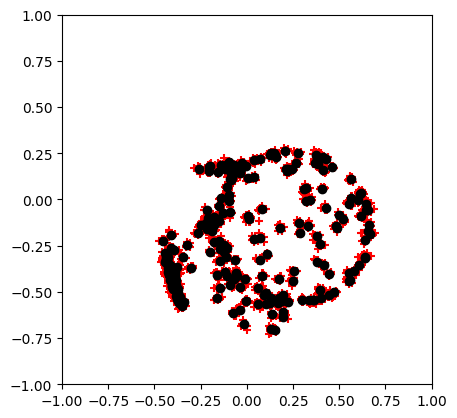

In [53]:
latents = dict(
    camera_positions=SCENE.camera_poses[1:].position.astype(DTYPE),
    camera_raw_quaternions=SCENE.camera_poses[1:].quaternion.astype(DTYPE),
    raw_observation_noise_scale=observation_noise_scale_bij.inverse(0.01).astype(DTYPE),
)
if MODEL.world_prior == "scale_free":
    latents.update(
        raw_keypoint_world_positions=SCENE.keypoint_world_positions.astype(
            DTYPE
        ).ravel(),
    )
else:
    latents.update(
        keypoint_world_positions=SCENE.keypoint_world_positions.astype(DTYPE),
    )

frame = 10
visible = SCENE.keypoint_visibility[frame]
with warnings.catch_warnings(action="ignore"):
    _, revals = jax.vmap(
        lambda i: model_cond_sample(
            functools.partial(MODEL.model, DEFAULT_MODEL_ARGS),
            latents,
            jax.random.key(i),
        )
    )(jnp.arange(10))

fig, ax = plt.subplots()
for i in range(10):
    retval = jax.tree.map(lambda x: x[i], revals)
    ax.scatter(
        *retval["keypoint_screen_positions"][frame, visible].T,
        marker="+",
        color="red",
    )
ax.scatter(*SCENE.keypoint_screen_positions[frame, visible].T, color="k")
ax.set_aspect("equal")
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

In [54]:
if MODEL.camera_prior == "relative_noncentered":
    print("This is broken for relative_noncentered.")

latents = dict(
    camera_positions=SCENE.camera_poses[1:].position.astype(DTYPE),
    camera_raw_quaternions=SCENE.camera_poses[1:].quaternion.astype(DTYPE),
    raw_observation_noise_scale=observation_noise_scale_bij.inverse(0.01).astype(DTYPE),
    keypoint_screen_positions=SCENE.keypoint_screen_positions.astype(DTYPE),
)
if MODEL.world_prior == "scale_free":
    latents.update(
        raw_keypoint_world_positions=SCENE.keypoint_world_positions.astype(
            DTYPE
        ).ravel(),
    )
else:
    latents.update(
        keypoint_world_positions=SCENE.keypoint_world_positions.astype(DTYPE),
    )

with warnings.catch_warnings(action="ignore"):
    lp, retval = model_log_prob(
        functools.partial(MODEL.model, DEFAULT_MODEL_ARGS), latents
    )

In [55]:
lp

Array(154142.5, dtype=float32)

In [56]:
retval["keypoint_screen_positions"][6, :5]

Array([[ 2.7765479e-04, -3.3200166e-01],
       [ 2.6322114e-01, -3.6610842e-01],
       [ 2.5917935e-01, -4.0534180e-01],
       [ 1.8391137e-01, -4.5538378e-01],
       [ 1.5793559e-01, -6.2384421e-01]], dtype=float32)

In [57]:
SCENE.keypoint_screen_positions[6, :5]

Array([[ 2.7765479e-04, -3.3200166e-01],
       [ 2.6322114e-01, -3.6610842e-01],
       [ 2.5917935e-01, -4.0534180e-01],
       [ 1.8391137e-01, -4.5538378e-01],
       [ 1.5793559e-01, -6.2384421e-01]], dtype=float32)

In [58]:
retval["camera_poses"][6]

Pose(position=Array([ 1.9328486,  2.3730583, -1.3438673], dtype=float32), quaternion=Array([-0.18325463, -0.5151692 ,  0.78884625,  0.28060633], dtype=float32))

In [59]:
SCENE.camera_poses[6]

Pose(position=Array([ 1.9328486,  2.3730583, -1.3438673], dtype=float32), quaternion=Array([-0.18325464, -0.51516926,  0.7888464 ,  0.28060636], dtype=float32))

# Inference

## Initialization

In [92]:
def init_frame_gt(latents, frame, scene, model, model_args):
    del model_args
    # Inits a frame from the ground truth.
    latents = latents.copy()
    if frame > 0:
        match model.camera_prior:
            case "relative_noncentered":
                raise NotImplementedError()
            case "independent" | "relative_centered":
                latents["camera_positions"] = (
                    latents["camera_positions"]
                    .at[frame - 1]
                    .set(scene.camera_poses[frame].position)
                )
                latents["camera_raw_quaternions"] = (
                    latents["camera_raw_quaternions"]
                    .at[frame - 1]
                    .set(scene.camera_poses[frame].quaternion)
                )

    visibility = scene.keypoint_visibility[frame]
    if frame == 0:
        prev_visibility = np.zeros_like(visibility)
    else:
        prev_visibility = scene.keypoint_visibility[:frame].any(0)
    visibility = visibility & ~prev_visibility

    match model.world_prior:
        case "scale_free":
            latents["raw_keypoint_world_positions"] = jnp.where(
                jnp.repeat(visibility[:, jnp.newaxis], 3, axis=-1).ravel(),
                scene.keypoint_world_positions.ravel(),
                latents["raw_keypoint_world_positions"],
            )
        case _:
            latents["keypoint_world_positions"] = jnp.where(
                visibility[:, jnp.newaxis],
                scene.keypoint_world_positions,
                latents["keypoint_world_positions"],
            )

    return latents

In [83]:
def init_frame_unproject(latents, frame, scene, model, model_args):
    # Inits a frame from the previous frame.
    latents = latents.copy()
    if frame > 0:
        match model.camera_prior:
            case "relative_noncentered":
                latents["camera_positions"] = (
                    latents["camera_positions"].at[frame - 1].set(jnp.zeros(3))
                )
                latents["camera_raw_quaternions"] = (
                    latents["camera_raw_quaternions"]
                    .at[frame - 1]
                    .set(jnp.array([0, 0, 0, 1.0]))
                )
            case "independent" | "relative_centered":
                if frame == 1:
                    # This isn't ideal... should we eval the model again to get the first pose rather than grabbing it from the scene
                    latents["camera_positions"] = (
                        latents["camera_positions"]
                        .at[frame - 1]
                        .set(scene.camera_poses[0].position)
                    )
                    latents["camera_raw_quaternions"] = (
                        latents["camera_raw_quaternions"]
                        .at[frame - 1]
                        .set(scene.camera_poses[0].quaternion)
                    )
                else:
                    latents["camera_positions"] = (
                        latents["camera_positions"]
                        .at[frame - 1]
                        .set(latents["camera_positions"][frame - 2])
                    )
                    latents["camera_raw_quaternions"] = (
                        latents["camera_raw_quaternions"]
                        .at[frame - 1]
                        .set(latents["camera_raw_quaternions"][frame - 2])
                    )

    with warnings.catch_warnings(action="ignore"):
        ret = model.eval_model(latents, model_args)
    camera_poses = ret["camera_poses"]

    visibility = scene.keypoint_visibility[frame]
    if frame == 0:
        prev_visibility = np.zeros_like(visibility)
    else:
        prev_visibility = scene.keypoint_visibility[:frame].any(0)
    visibility = visibility & ~prev_visibility

    indices = jnp.where(visibility)[0]
    uvs = scene.keypoint_screen_positions[frame, indices]
    camera_pose = jax.tree.map(lambda x: x[frame], camera_poses)

    homogeneous_pixel_coords = homogeneous_coordinates(uvs, jnp.array(3.0, DTYPE))

    transformed = camera_pose.apply(homogeneous_pixel_coords)

    match model.world_prior:
        case "scale_free":
            latents["raw_keypoint_world_positions"] = (
                latents["raw_keypoint_world_positions"]
                .reshape([scene.num_keypoints, 3])
                .at[indices]
                .set(transformed)
                .ravel()
            )
        case _:
            latents["keypoint_world_positions"] = (
                latents["keypoint_world_positions"].at[indices].set(transformed)
            )

    return latents

### Tests

In [62]:
# Enable to run this test.
if False:
    latents = dict(
        camera_positions=SCENE.camera_poses[1:].position.astype(DTYPE),
        camera_raw_quaternions=SCENE.camera_poses[1:].quaternion.astype(DTYPE),
        raw_observation_noise_scale=observation_noise_scale_bij.inverse(0.01).astype(
            DTYPE
        ),
        keypoint_screen_positions=SCENE.keypoint_screen_positions.astype(DTYPE),
    )
    latents = {**prior_sample, **latents}

    with warnings.catch_warnings(action="ignore"):
        for i in range(1):
            latents = init_frame_unproject(latents, i, SCENE, MODEL, DEFAULT_MODEL_ARGS)

    retval = MODEL.eval_model(latents, DEFAULT_MODEL_ARGS)

    scene_points = PointsDisplay(
        positions=retval["keypoint_world_positions"],
        colors=SCENE.keypoint_colors,
        point_size=4,
    )

    scene_camera = CameraDisplay(
        positions=retval["camera_poses"].position,
        quaternions=retval["camera_poses"].quaternion,
        color=np.array([1.0, 0.0, 0.0]),
    )

    scene_renderer = SceneRenderer(scene_points.objects + scene_camera.objects)

    display(scene_renderer.renderer)

## HMC

In [63]:
def add_camera_quaternion(latents):
    latents = latents.copy()
    latents["camera_quaternions"] = latents["camera_raw_quaternions"] / jnp.linalg.norm(
        latents["camera_raw_quaternions"], axis=-1, keepdims=True
    )
    return latents


class HMCInferenceState(NamedTuple):
    latents: Any
    ssa_state: fun_mc.prefab.StepSizeAdaptationState
    rvar_state: fun_mc.RunningVarianceState
    rvar_state_slow: fun_mc.RunningVarianceState
    mean_sq_grad: Any


class HMCInferenceExtra(NamedTuple):
    target_log_prob: Any
    tlp_extra: Any
    traced: Any
    logged: Any
    extra: Any


@dataclasses.dataclass(frozen=True)
class HMCInference:
    model: Model
    init_frame_latents_fn: Any
    num_chains: int = 8
    test_camera_idx: int = 10

    @functools.partial(jax.jit, static_argnums=(0,))
    def init_fn(self, latents, init_step_size):
        latents = jax.tree.map(
            lambda x: jnp.repeat(x[jnp.newaxis], self.num_chains, axis=0), latents
        )
        rvar_latents = add_camera_quaternion(latents)
        return HMCInferenceState(
            latents=latents,
            ssa_state=jax.vmap(fun_mc.prefab.step_size_adaptation_init)(
                jnp.repeat(
                    jnp.array(init_step_size, DTYPE)[jnp.newaxis], self.num_chains
                )
            ),
            rvar_state=jax.vmap(
                lambda l: fun_mc.running_variance_init(
                    jax.tree.map(lambda x: x.shape, l),
                    jax.tree.map(lambda x: x.dtype, l),
                )
            )(rvar_latents),
            rvar_state_slow=jax.vmap(
                lambda l: fun_mc.running_variance_init(
                    jax.tree.map(lambda x: x.shape, l),
                    jax.tree.map(lambda x: x.dtype, l),
                )
            )(rvar_latents),
            mean_sq_grad=jax.tree.map(jnp.ones_like, latents),
        )

    @functools.partial(jax.jit, static_argnums=(0,))
    def step_fn(
        self,
        state,
        step,
        cond_latents,
        cond_mask,
        model_args,
        mean_num_leapfrog_steps,
        adapt=True,
    ):
        print("tracing")
        hmc_seed, jitter_seed = jax.random.split(jax.random.key(step))
        tlp_fn = jax.vmap(
            functools.partial(
                self.model.target_log_prob_fn,
                cond_latents=cond_latents,
                cond_mask=cond_mask,
                model_args=model_args,
            )
        )

        latents = state.latents.copy()
        for k, v in list(cond_latents.items()):
            mask = cond_mask.get(k)
            if mask is not None:
                latents[k] = jnp.where(mask, v, latents[k])

        hmc_state = fun_mc.hamiltonian_monte_carlo_init([latents], tlp_fn)

        num_integrator_steps = jax.random.randint(
            jitter_seed, [], 1, 1 + 2 * mean_num_leapfrog_steps
        )
        step_size = jnp.where(
            adapt, state.ssa_state.step_size(), state.ssa_state.rms_step_size
        )

        def step_size_part(v):
            return step_size.reshape(
                [self.num_chains] + [1] * (len(v.shape) - 1)
            )  # / (1e-5 + jnp.sqrt(v))

        vec_step_size = [jax.tree.map(step_size_part, state.mean_sq_grad)]

        hmc_state, hmc_extra = fun_mc.hamiltonian_monte_carlo_step(
            hmc_state,
            target_log_prob_fn=tlp_fn,
            step_size=vec_step_size,
            num_integrator_steps=num_integrator_steps,
            seed=jax.random.fold_in(hmc_seed, 0),
            # energy_change_fn=energy_change_fn,
        )
        hmc_state, hmc_extra = fun_mc.hamiltonian_monte_carlo_step(
            hmc_state,
            target_log_prob_fn=tlp_fn,
            step_size=vec_step_size,
            num_integrator_steps=2 * mean_num_leapfrog_steps - num_integrator_steps,
            seed=jax.random.fold_in(hmc_seed, 1),
            # energy_change_fn=energy_change_fn,
        )

        latents = hmc_state.state_extra["latents"]

        ssa_state, _ = jax.vmap(
            lambda ssa_state, log_accept_ratio: fun_mc.prefab.step_size_adaptation_step(
                ssa_state,
                log_accept_ratio=log_accept_ratio,
                num_adaptation_steps=None,
                target_accept_prob=0.95,
                adaptation_rate=0.2,
                # reduce_fn=tfp.math.reduce_log_harmonic_mean_exp,
            )
        )(state.ssa_state, hmc_extra.log_accept_ratio)

        rvar_latents = add_camera_quaternion(latents)
        rvar_state, _ = jax.vmap(
            lambda s, l: fun_mc.running_variance_step(s, l, window_size=200)
        )(state.rvar_state, rvar_latents)
        rvar_state_slow, _ = jax.vmap(
            lambda s, l: fun_mc.running_variance_step(s, l, window_size=400)
        )(state.rvar_state_slow, rvar_latents)

        all_means, all_vars = jax.tree.map(
            lambda x, y: jnp.concatenate([x, y], 0),
            (rvar_state.mean, rvar_state.variance),
            (rvar_state_slow.mean, rvar_state_slow.variance),
        )
        rhats = jax.tree.map(
            lambda mean, var: 1.0 + mean.var(0) / var.mean(0),
            all_means,
            all_vars,
        )
        worst_rhats = jax.tree.map(lambda rhat: jnp.nanmax(rhat), rhats)
        worst_rhats = {f"{k} rhat": v for k, v in worst_rhats.items()}

        lr = 0.05

        def sq_grad_part(mean_sq_grad, g):
            g = jnp.where(jnp.isfinite(g), g, 0.0)
            new = jnp.square(g)
            new = jnp.clip(
                new, (1 - lr**0.1) * mean_sq_grad, (1 + lr**0.1) * mean_sq_grad
            )
            return mean_sq_grad * (1 - lr) + new * lr

        mean_sq_grad = jax.tree.map(
            sq_grad_part, state.mean_sq_grad, hmc_state.state_grads[0]
        )

        tlp_extra = hmc_state.state_extra

        camera_poses = tlp_extra["camera_poses"]

        extra = HMCInferenceExtra(
            target_log_prob=hmc_state.target_log_prob,
            traced=collections.OrderedDict(
                {
                    "target_log_prob": hmc_state.target_log_prob,
                    "step_size": step_size,
                    "observation_noise_scale": hmc_state.state_extra[
                        "observation_noise_scale"
                    ],
                    f"camera_positions[{self.test_camera_idx}].x": camera_poses.position[
                        :, self.test_camera_idx, 0
                    ],
                    f"camera_positions[{self.test_camera_idx}].y": camera_poses.position[
                        :, self.test_camera_idx, 1
                    ],
                    f"camera_quaternions[{self.test_camera_idx}].x": camera_poses.quaternion[
                        :, self.test_camera_idx, 0
                    ],
                    f"camera_quaternions[{self.test_camera_idx}].y": camera_poses.quaternion[
                        :, self.test_camera_idx, 1
                    ],
                }
            ),
            logged=collections.OrderedDict(
                {
                    "log_accept_ratio": hmc_extra.log_accept_ratio.min(),
                    "log_accept_ratio_old": (
                        -hmc_extra.integrator_extra.energy_change
                    ).min(),
                    **worst_rhats,
                }
            ),
            tlp_extra=hmc_state.state_extra,
            extra={
                "rhats": rhats,
            },
        )

        # TODO: disable pre-conditioning as well
        ssa_state = jax.tree.map(
            lambda n, o: jnp.where(adapt, n, o), ssa_state, state.ssa_state
        )

        return state._replace(
            latents=latents,
            ssa_state=ssa_state,
            rvar_state=rvar_state,
            rvar_state_slow=rvar_state_slow,
            mean_sq_grad=mean_sq_grad,
        ), extra

    @functools.partial(jax.jit, static_argnums=(0,))
    def resample_fn(self, state, indices):
        resample = lambda s: s[indices]
        return jax.tree.map(resample, state)

    def init_frame_fn(self, state, frame, scene, model_args):
        return state._replace(
            latents=jax.vmap(
                lambda l: self.init_frame_latents_fn(
                    latents=l,
                    frame=frame,
                    scene=scene,
                    model=self.model,
                    model_args=model_args,
                )
            )(state.latents)
        )

    def get_ground_truth(self, scene):
        return {
            f"camera_positions[{self.test_camera_idx}].x": scene.camera_poses.position[
                self.test_camera_idx, 0
            ],
            f"camera_positions[{self.test_camera_idx}].y": scene.camera_poses.position[
                self.test_camera_idx, 1
            ],
            f"camera_quaternions[{self.test_camera_idx}].x": scene.camera_poses.quaternion[
                self.test_camera_idx, 0
            ],
            f"camera_quaternions[{self.test_camera_idx}].y": scene.camera_poses.quaternion[
                self.test_camera_idx, 1
            ],
        }

    def get_hparams(self):
        return {
            "mean_num_leapfrog_steps": Hyperparameter(50, 1, 400),
        }

## Construct

When constructing the inference method, we specify how to initialize new frames. By default, this grabs the data from the ground truth, but a ground-truth-free method of unprjecting newly added points is also available.

In [99]:
INFERENCE = HMCInference(
    model=MODEL,
    init_frame_latents_fn=init_frame_gt,
    #init_frame_latents_fn=init_frame_unproject,
    num_chains=4,
)

with warnings.catch_warnings(action="ignore"):
    prior_sample, retval = model_sample(
        functools.partial(MODEL.model, DEFAULT_MODEL_ARGS), jax.random.key(0)
    )
    del prior_sample["keypoint_screen_positions"]
    # Note that the real initialization happens in INFERENCE.init_frame_fn
    INIT_LATENTS = prior_sample

## Tests

In [94]:
# Enable to run this test.
if False:
    with warnings.catch_warnings(action="ignore"):
        init_state = INFERENCE.init_fn(INIT_LATENTS, 1e-3)
        for i in range(SCENE.num_frames):
            init_state = INFERENCE.init_frame_fn(
                init_state, i, SCENE, DEFAULT_MODEL_ARGS
            )

        cond_latents = {
            "keypoint_screen_positions": SCENE.keypoint_screen_positions.astype(DTYPE),
            "raw_observation_noise_scale": observation_noise_scale_bij.inverse(
                0.01,
            ).astype(DTYPE),
        }
        cond_mask = {
            "raw_observation_noise_scale": True,
        }
        state = init_state
        for i in range(100):
            state, extra = INFERENCE.step_fn(
                state,
                i,
                cond_latents,
                cond_mask,
                DEFAULT_MODEL_ARGS,
                # DEFAULT_MODEL_ARGS._replace(
                #    keypoint_visibility=scene.keypoint_visibility.at[1:].set(False)
                # ),
                40,
            )
            print()
            print("lp_a  ", extra.logged["log_accept_ratio"])
            print("lp_a_o", extra.logged["log_accept_ratio_old"])
            print("tlp", extra.traced["target_log_prob"])
            print("ss", extra.traced["step_size"])
        print(extra.logged)
        print(extra.traced)

# Interactive Inference

In [97]:
class InteractiveInference:
    def __init__(self, scene, model, inference, model_args, init_latents):
        self.scene = scene
        self.model = model
        self.inference = inference
        self.cur_num_frames = 1
        self.target_num_frames = 1
        self.auto_advance_frames = Hyperparameter(False)
        self.auto_advance_interval = Hyperparameter(20, 1, 200)
        self.step = 0
        self.observation_noise_scale = Hyperparameter(1e-2, 1e-4, 1e2, log_scale=True)
        self.observation_noise_scale_override = Hyperparameter(True)
        self.observation_noise_degrees = Hyperparameter(
            model_args.observation_noise_degrees,
            1,
            1000,
            log_scale=True,
        )
        self.object_prior_scale = Hyperparameter(
            model_args.object_prior_scale, 1e-3, 1e4, log_scale=True
        )
        self.model_args = model_args
        init_state = inference.init_fn(init_latents, 1e-6)
        self.state = inference.init_frame_fn(
            state=init_state, frame=0, scene=self.scene, model_args=self.model_args
        )
        self.auto_resample = Hyperparameter(False)
        self.resample = False
        self.super_resample = False
        self.num_resample = 0
        self.show_covariance = Hyperparameter(True)
        self.show_errors = Hyperparameter(True)
        self.show_chain = Hyperparameter(-1, -1, self.inference.num_chains - 1)
        self.show_frame = Hyperparameter(-1, -1, self.scene.num_frames - 1)
        self.pause = Hyperparameter(True)
        self.hparams = {k: copy.copy(v) for k, v in inference.get_hparams().items()}

        # Precompile (why do I need to do this twice?)
        s, extra = self.run_step(self.state)
        s, extra = self.run_step(s)
        tlp_extra = extra.tlp_extra

        self.trace = {k: [v] for k, v in extra.traced.items()}

        loc, cov = get_loc_cov(tlp_extra["keypoint_world_positions"])

        self.gt_camera_display = CameraDisplay(
            positions=self.scene.camera_poses.position,
            quaternions=self.scene.camera_poses.quaternion,
            color=np.array([1.0, 0.0, 0.0]),
        )
        self.gt_points_display = PointsDisplay(
            positions=self.scene.keypoint_world_positions,
            colors=np.zeros_like(self.scene.keypoint_colors)
            + np.array([1.0, 0.0, 0.0], dtype=np.float32),
            point_size=2,
        )
        chain_cmap = plt.colormaps["viridis"]
        self.camera_displays = [
            CameraDisplay(
                positions=tlp_extra["camera_poses"].position[i],
                quaternions=tlp_extra["camera_poses"].quaternion[i],
                color=chain_cmap(i / (self.inference.num_chains - 1)),
            )
            for i in range(self.inference.num_chains)
        ]
        self.points_display = PointsDisplay(
            positions=self.scene.keypoint_world_positions,
            colors=self.scene.keypoint_colors,
        )
        self.blobs_display = BlobDisplay(
            positions=loc,
            colors=self.scene.keypoint_colors,
            covariances=cov + 0.01 * np.eye(3),
        )
        self.error_display = PointsDisplay(
            positions=self.scene.keypoint_world_positions,
            colors=np.repeat(
                np.array([1.0, 1.0, 0.0], np.float32)[np.newaxis],
                self.scene.num_keypoints,
                axis=0,
            ),
        )
        self.scene_renderer = SceneRenderer(
            self.gt_camera_display.objects
            + self.gt_points_display.objects
            + self.blobs_display.objects
            + self.points_display.objects
            + self.error_display.objects
            + [o for c in self.camera_displays for o in c.objects]
        )
        self.status = None
        self.output = ipywidgets.Output()

        widgets = []
        widgets.append(
            make_hyperparameter_widget(
                self.pause,
                "",
                self.output,
                toggle_style="info",
                toggle_icons=("pause", "play"),
            )
        )

        def on_stop_button(_):
            try:
                self.quit = True
            except Exception:
                with self.output:
                    print(traceback.format_exc())

        def on_resample_button(_):
            try:
                self.resample = True
            except Exception:
                with self.output:
                    print(traceback.format_exc())

        def on_super_resample_button(_):
            try:
                self.resample = True
                self.super_resample = True
            except Exception:
                with self.output:
                    print(traceback.format_exc())

        stop_button = ipywidgets.Button(description="⏼", button_style="danger")
        stop_button.on_click(on_stop_button)
        resample_button = ipywidgets.Button(
            description="Resample", button_style="warning"
        )
        resample_button.on_click(on_resample_button)
        super_resample_button = ipywidgets.Button(
            description="!!Resample!!", button_style="danger"
        )
        super_resample_button.on_click(on_super_resample_button)

        widgets.append(
            ipywidgets.Accordion(
                children=[
                    ipywidgets.HBox(
                        [
                            stop_button,
                            resample_button,
                            super_resample_button,
                            make_hyperparameter_widget(
                                self.auto_resample, "Auto Resample", self.output
                            ),
                        ]
                    )
                ],
                titles=["Angry Buttons"],
            )
        )

        def change_target_num_frames(new_target_num_frames):
            try:
                self.target_num_frames = np.clip(
                    new_target_num_frames, 1, self.scene.num_frames
                )
                frame_mask = np.arange(self.scene.num_frames) < self.target_num_frames
                keypoint_mask = self.scene.keypoint_visibility[
                    : self.target_num_frames
                ].any(0)

                self.gt_camera_display.set_mask(frame_mask)
                for i, camera_display in enumerate(self.camera_displays):
                    if self.show_chain.value == -1:
                        camera_mask = np.array(True)
                    else:
                        camera_mask = np.array(i == self.show_chain.value)
                    camera_display.set_mask(camera_mask & frame_mask)

                self.gt_points_display.set_mask(keypoint_mask)
                self.points_display.set_mask(keypoint_mask)
                self.blobs_display.set_mask(
                    int(self.show_covariance.value) * keypoint_mask
                )

                frame_text.value = (
                    f"Num frames: {self.target_num_frames}/{self.scene.num_frames}"
                )
            except Exception as e:
                with self.output:
                    print(traceback.format_exc())

        # Oof
        self.change_target_num_frames = change_target_num_frames

        def on_add_frame(_):
            change_target_num_frames(self.target_num_frames + 1)

        def on_add_all_frames(_):
            change_target_num_frames(self.scene.num_frames)

        def on_remove_frame(_):
            change_target_num_frames(self.target_num_frames - 1)

        add_frame_button = ipywidgets.Button(description="Add Frame")
        add_all_frames_button = ipywidgets.Button(
            description="Add ALL Frames", button_style="warning"
        )
        remove_frame_button = ipywidgets.Button(description="Remove Frame")
        frame_text = ipywidgets.Label()
        add_frame_button.on_click(on_add_frame)
        add_all_frames_button.on_click(on_add_all_frames)
        remove_frame_button.on_click(on_remove_frame)

        # This sets up the initial masks.
        change_target_num_frames(self.target_num_frames)

        widgets.append(
            ipywidgets.HBox(
                [
                    add_frame_button,
                    add_all_frames_button,
                    remove_frame_button,
                    make_hyperparameter_widget(
                        self.auto_advance_frames, "Auto Advance", self.output
                    ),
                    frame_text,
                ]
            )
        )

        widgets.append(
            make_hyperparameter_widget(
                self.auto_advance_interval, "Auto advance interval", self.output
            )
        )

        widgets.append(
            ipywidgets.HBox(
                [
                    make_hyperparameter_widget(
                        self.show_covariance,
                        "Show blobs",
                        self.output,
                        callback_fn=lambda _: change_target_num_frames(
                            self.target_num_frames
                        ),
                    ),
                    make_hyperparameter_widget(
                        self.show_errors,
                        "Show errors",
                        self.output,
                        callback_fn=lambda _: change_target_num_frames(
                            self.target_num_frames
                        ),
                    ),
                ]
            )
        )
        widgets.append(
            make_hyperparameter_widget(
                self.show_chain,
                "Show chain",
                self.output,
                lambda _: change_target_num_frames(self.target_num_frames),
            )
        )
        widgets.append(
            make_hyperparameter_widget(self.show_frame, "Show frame", self.output)
        )

        widgets.append(
            ipywidgets.Accordion(
                children=[
                    ipywidgets.VBox(
                        [
                            ipywidgets.HBox(
                                [
                                    make_hyperparameter_widget(
                                        self.observation_noise_scale,
                                        "observation_noise_scale",
                                        self.output,
                                    ),
                                    make_hyperparameter_widget(
                                        self.observation_noise_scale_override,
                                        "Override",
                                        self.output,
                                    ),
                                ]
                            ),
                            make_hyperparameter_widget(
                                self.observation_noise_degrees,
                                "observation_noise_degrees",
                                self.output,
                            ),
                            make_hyperparameter_widget(
                                self.object_prior_scale,
                                "object_prior_scale",
                                self.output,
                            ),
                        ]
                    )
                ],
                titles=["Model hyperparameters"],
            )
        )

        widgets.append(
            ipywidgets.Accordion(
                children=[
                    make_hyperparameter_widget(v, k, self.output)
                    for k, v in self.hparams.items()
                ],
                titles=["Inference hyperparameters"],
            )
        )

        figures = {}
        ground_truth = self.inference.get_ground_truth(self.scene)
        for k, v in self.trace.items():
            traces = []
            for i in range(np.size(v)):
                traces.append(
                    pgo.Scatter(
                        x=[],
                        y=[],
                        line_color=to_html(
                            chain_cmap(i / (self.inference.num_chains - 1))
                        ),
                    )
                )
            fig = pgo.FigureWidget(
                data=traces,
                layout=pgo.Layout(
                    title=dict(text=k),
                    margin=dict(l=1, r=1, t=30, b=1),
                    height=100,
                ),
            )
            if k in ground_truth:
                fig.add_hline(y=float(ground_truth[k]), line_color="red")
            # if k in ['step_size']:
            #    fig.update_yaxes(type="log")
            fig.update_layout(showlegend=False)
            figures[k] = fig

        h = ipywidgets.HTML("Output", layout=ipywidgets.Layout(width="1000px"))

        widgets.append(self.output)

        output2 = ipywidgets.Output()
        with output2:
            display(self.scene_renderer)

        widgets.append(
            ipywidgets.HBox([output2, ipywidgets.VBox(list(figures.values()))])
        )

        widgets.append(h)

        self.figures = figures
        self.widgets = widgets
        self.h = h
        self.quit = False

    def run_step(self, state):
        cond_latents = {
            "keypoint_screen_positions": self.scene.keypoint_screen_positions.astype(
                DTYPE
            ),
            "raw_observation_noise_scale": observation_noise_scale_bij.inverse(
                self.observation_noise_scale.value
            ),
            "camera_positions": jnp.ones_like(self.scene.camera_poses.position)[
                1:
            ].astype(DTYPE),
            "camera_raw_quaternions": jnp.ones_like(self.scene.camera_poses.quaternion)[
                1:
            ].astype(DTYPE),
        }
        cond_mask = {
            "raw_observation_noise_scale": np.array(
                self.observation_noise_scale_override.value
            ),
            "camera_positions": ~self.model_args.camera_visibility[1:, jnp.newaxis],
            "camera_raw_quaternions": ~self.model_args.camera_visibility[
                1:, jnp.newaxis
            ],
        }
        hparams_kwargs = {k: v.value for k, v in self.hparams.items()}
        return self.inference.step_fn(
            state,
            self.step,
            cond_latents,
            cond_mask,
            self.model_args,
            **hparams_kwargs,
        )

    def _ipython_display_(self):
        if not self.quit:
            display(*self.widgets)
            self.task = asyncio.create_task(self.animate())

    def __del__(self):
        self.quit = True

    def set_output(self, s):
        content = "<br>".join(s.split("\n"))
        self.h.value = content

    def stop(self):
        self.quit = True

    async def animate(self):
        try:
            while not self.quit:
                if (
                    self.auto_advance_frames.value
                    and (self.step + 1) % self.auto_advance_interval.value == 0
                ):
                    self.change_target_num_frames(self.target_num_frames + 1)

                self.model_args = self.model_args._replace(
                    camera_visibility=(
                        jnp.arange(self.scene.num_frames) < self.target_num_frames
                    ),
                    keypoint_visibility=self.scene.keypoint_visibility.at[
                        self.target_num_frames :
                    ].set(False),
                    observation_noise_degrees=jnp.array(
                        self.observation_noise_degrees.value, DTYPE
                    ),
                    object_prior_scale=jnp.array(self.object_prior_scale.value),
                )
                for frame in range(self.cur_num_frames, self.target_num_frames):
                    self.state = self.inference.init_frame_fn(
                        state=self.state,
                        frame=frame,
                        scene=self.scene,
                        model_args=self.model_args,
                    )
                self.cur_num_frames = self.target_num_frames

                start = time.time()
                new_state, extra = self.run_step(self.state)
                end = time.time()
                tlp_extra = extra.tlp_extra

                if not self.pause.value:
                    self.state = new_state
                if self.super_resample:
                    self.super_resample = False
                    resample_strength = 1.0
                else:
                    resample_strength = 1e-3

                if (self.auto_resample.value or self.resample) or not jnp.all(
                    jnp.isfinite(extra.target_log_prob)
                ):
                    (_, _), ancestor_idx = fun_mc.resample(
                        (),
                        resample_strength * extra.target_log_prob,
                        jax.random.key(self.step),
                    )
                    self.state = self.inference.resample_fn(self.state, ancestor_idx)
                    self.num_resample += 1
                    self.resample = False

                if not self.pause.value:
                    for k in self.trace.keys():
                        self.trace[k].append(extra.traced[k])

                loc, cov = get_loc_cov(tlp_extra["keypoint_world_positions"])

                for i, camera_display in enumerate(self.camera_displays):
                    camera_display.set_state(
                        positions=tlp_extra["camera_poses"].position[i],
                        quaternions=tlp_extra["camera_poses"].quaternion[i],
                    )
                show_chain = max(0, self.show_chain.value)
                self.points_display.set_state(
                    positions=tlp_extra["keypoint_world_positions"][show_chain],
                )
                self.blobs_display.set_state(
                    positions=loc,
                    covariances=9 * cov,
                )
                show_frame = self.show_frame.value
                if show_frame < 0:
                    show_frame = self.cur_num_frames - 1
                error_sizes = (
                    1.0 + 25. * tlp_extra["l1_errors"][show_chain, show_frame]
                )
                error_sizes = np.where(np.isfinite(error_sizes), error_sizes, 0.0)
                self.error_display.set_mask(
                    int(self.show_errors.value)
                    * self.scene.keypoint_visibility[show_frame].astype(DTYPE)
                    * error_sizes,
                )

                for k, trace in self.trace.items():
                    if len(trace) <= 1:
                        continue
                    trace = np.array(trace)
                    trace = trace.reshape([len(trace), -1])[1:]
                    fig = self.figures[k]
                    w = 200
                    last_half = trace[-w:]
                    span = np.nanmax(last_half) - np.nanmin(last_half)
                    with fig.batch_update():
                        for j in range(trace.shape[-1]):
                            x = np.arange(len(trace))[-w:]
                            y = trace[:, j][-w:]
                            x = x[np.isfinite(y)]
                            y = y[np.isfinite(y)]
                            fig.data[j].x = x
                            fig.data[j].y = y
                        if False:
                            fig.update_yaxes(
                                range=[
                                    np.nanmin(last_half) - span * 0.1,
                                    np.nanmax(last_half) + span * 0.1,
                                ]
                            )

                if self.status is None:
                    self.set_output(
                        "\n".join(
                            [
                                f"step: {self.step}",
                                f"step time: {end - start:.2f}",
                                f"num resample: {self.num_resample}",
                            ]
                            + [f"{k}: {float(v):.2f}" for k, v in extra.logged.items()]
                        )
                    )
                else:
                    self.set_output(self.status)
                    self.quit = True
                if not self.pause.value:
                    self.step += 1
                await asyncio.sleep(1 / 10)
        except Exception as e:
            with self.output:
                print(traceback.format_exc())
            self.quit = True

## Run

By default, this will not infer the observation noise scale, since for this synthetic example, there is no noise. When initializing frames via unprojection, it's important to add them one-by-one, and let the inference stabilize.

In [98]:
if INTERACTIVE_INFERENCE is not None:
    INTERACTIVE_INFERENCE.stop()

with warnings.catch_warnings(action="ignore"):
    INTERACTIVE_INFERENCE = InteractiveInference(
        scene=SCENE,
        model=MODEL,
        inference=INFERENCE,
        model_args=DEFAULT_MODEL_ARGS,
        init_latents=INIT_LATENTS,
    )
    display(INTERACTIVE_INFERENCE)

ToggleButton(value=True, button_style='info', icon='pause')

Accordion(children=(HBox(children=(Button(button_style='danger', description='⏼', style=ButtonStyle()), Button…

IntSlider(value=20, description='Auto advance interval', layout=Layout(width='500px'), max=200, min=1, style=S…

IntSlider(value=-1, description='Show chain', layout=Layout(width='500px'), max=3, min=-1, style=SliderStyle(d…

IntSlider(value=-1, description='Show frame', layout=Layout(width='500px'), max=99, min=-1, style=SliderStyle(…

Accordion(children=(VBox(children=(HBox(children=(FloatLogSlider(value=0.01, description='observation_noise_sc…

Accordion(children=(IntSlider(value=50, description='mean_num_leapfrog_steps', layout=Layout(width='500px'), m…

Output()

    'data': [{'line': {'color': '#440154'},
           …

HTML(value='Output', layout=Layout(width='1000px'))

# Batch Inference (Non-incremental)

In [110]:
class BatchInference:
    def __init__(
        self,
        model,
        inference,
        scene,
        model_args,
        init_latents,
        num_steps,
        num_warmup_steps,
        num_leapfrog_steps,
    ):
        self.model = model
        self.inference = inference
        self.scene = scene
        self.model_args = model_args
        
        init_state = self.inference.init_fn(init_latents, 1e-6)
        for i in range(self.scene.num_frames):
            init_state = self.inference.init_frame_fn(init_state, i, self.scene, self.model_args)

        cond_latents = {
            "keypoint_screen_positions": self.scene.keypoint_screen_positions.astype(
                DTYPE
            ),
            "raw_observation_noise_scale": observation_noise_scale_bij.inverse(
                1e-2
            ).astype(DTYPE),
        }
        cond_mask = {
            "raw_observation_noise_scale": True,
        }

        @jax.jit
        def kernel(state, step):
            state, extra = self.inference.step_fn(
                state,
                step,
                cond_latents,
                cond_mask,
                self.model_args,
                num_leapfrog_steps,
                adapt=step < int(num_warmup_steps * 0.8),
            )
            traced = extra.traced
            final = {"rhats": extra.extra["rhats"]}
            return (state, step + 1), (traced, final)

        it_state = fun_mc.interruptible_trace_init(
            state=(init_state, 0),
            fn=kernel,
            num_steps=num_warmup_steps + num_steps,
            trace_mask=(True, False),
        )

        self.it_state = it_state
        self.kernel = kernel

        self.num_steps = num_steps
        self.num_warmup_steps = num_warmup_steps
        self.output = ipywidgets.Output()
        self.image = ipywidgets.Image(format="png")
        self.widgets = [ipywidgets.VBox([self.output, self.image])]

    def run(self):
        display(*self.widgets)

        with self.output:
            for i in tqdm.notebook.tqdm(range(self.num_steps + self.num_warmup_steps)):
                start = time.time()
                self.it_state, _ = fun_mc.interruptible_trace_step(
                    self.it_state, self.kernel
                )
                if i == 10:
                    print(f'Iter time (sec): {time.time() - start:.2f}')

                if (i + 1) % 100 == 0:
                    traced, final = self.it_state.trace()
                    fig = self.trace_plot(traced, final)
                    bytes_io = io.BytesIO()
                    fig.savefig(bytes_io, format="png")
                    plt.close(fig)

                    self.image.value = bytes_io.getvalue()

    def trace_plot(self, traced, final):
        fig, axs = plt.subplots(len(traced), 2, squeeze=False, figsize=(12, 10))
        t = np.arange(len(jax.tree.leaves(traced)[0]))
        ground_truth = self.inference.get_ground_truth(self.scene)
        for i, (k, v) in enumerate(traced.items()):
            for j, s in enumerate([np.s_[:], np.s_[-100:]]):
                ax = axs[i, j]
                ax.plot(t[s], v[s])

                if k in ground_truth:
                    ax.axhline(ground_truth[k], color="red", lw=2)
                ax.set_title(k)

                ax.minorticks_on()
                ax.grid(which="both")
                ax.grid(which="minor", ls="--", alpha=0.5)

        fig.tight_layout()
        return fig

    def rhat_plot(self, traced, final):
        rhats = final["rhats"]
        fig, axs = plt.subplots(len(rhats), figsize=(3, 2 * len(rhats)))

        for i, (k, v) in enumerate(rhats.items()):
            ax = axs[i]
            ax.hist(v.ravel(), bins=40, log=True, range=(1, v.max()))

            ax.set_title(f"{k} rhat")
            ax.minorticks_on()
            ax.grid(which="both")
            ax.grid(which="minor", ls="--", alpha=0.5)
        fig.tight_layout()
        return fig

    def rhat_keypoint_world_positions_plot(self, traced, final):
        fig, ax = plt.subplots()
        rhats = final["rhats"]
        keypoint_rhats = rhats["keypoint_world_positions"].ravel()
        ax.scatter(
            jnp.repeat(self.scene.keypoint_visibility.sum(0)[:, jnp.newaxis], 3, axis=-1).ravel(),
            keypoint_rhats - 1,
        )
        ax.set_yscale("log")
        ax.set_title("keypoint_world_positions rhats")
        ax.set_xlabel("num frames visible")
        ax.set_ylabel("rhat - 1")

        ax.minorticks_on()
        ax.grid(which="both")
        ax.grid(which="minor", ls="--", alpha=0.5)
        return fig

## Run

In [113]:
with warnings.catch_warnings(action="ignore"):
    batch_inference = BatchInference(
        model=MODEL,
        scene=SCENE,
        inference=INFERENCE,
        init_latents=INIT_LATENTS,
        model_args=DEFAULT_MODEL_ARGS,
        num_leapfrog_steps=400,
        num_warmup_steps=500,
        num_steps=1000,
    )
    batch_inference.run()

In [114]:
traced, final = batch_inference.it_state.trace()

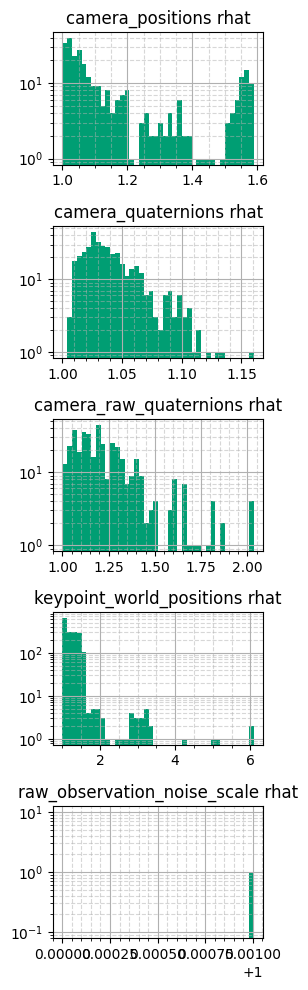

In [115]:
batch_inference.rhat_plot(traced, final);

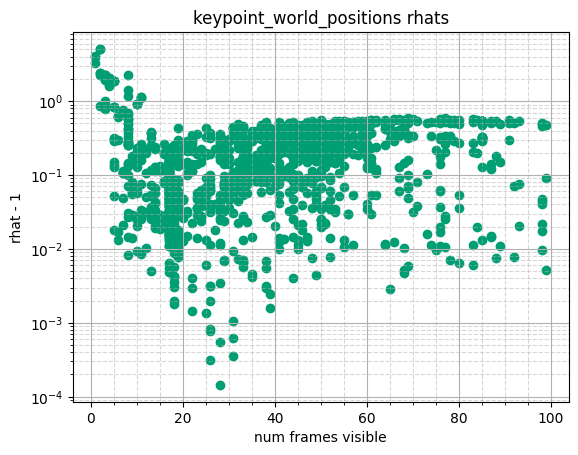

In [116]:
batch_inference.rhat_keypoint_world_positions_plot(traced, final);